# Anàlisi causal: Estudi de les relacions causa-efecte i aplicació a l'anàlisi de dades
### Treball final del doble grau Matemàtiques - Enginyeria informàtica


## Pràctica: anàlisi de la relació entre precipitació, temperatura i ús de la bicicleta a Barcelona

_Aleix Ràmia Rodríguez_

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import timeit
import scipy

import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import causalinference
import statsmodels.api as sm

In [9]:
study_dates = [[2020,[1,2]],[2019,[3,4,5,6,7,8,9,10,11,12]]]
study_var = 'num_bikes_available'
header_file_name = 'bikes_db_header.csv'
figroute = "./Graphs/"
station_ids = np.load('station_ids.npy',allow_pickle=True)

stations_pickle_filename = '1_StationsData'
weather_pickle_filename = '2_WeatherData'
db_pickle_filename = '3_StudyData'

# PART 1: Preparació de dades i experiment

## Part 1.1
Comencem important les dades de les nostres estacions, agrupant en una mateixa taula les dades de tots els mesos per totes les estacions

In [4]:
def access_bike_csv(year,month):
    namefile = str(year) + "_" + str(month) + ".csv"
    db_add = pd.read_csv(namefile)
    db_add['datetime'] = pd.to_datetime(db_add['last_updated']+3600, unit='s', origin='unix') 
    return db_add

def access_weather(filename):
    weather_db = pd.read_csv(filename)
    
    weather_db['datetime'] = pd.to_datetime(weather_db['datetime'], format='%Y-%m-%d %H:%M:%S')
    
    weather_db['date_ref'] = weather_db['datetime'].dt.strftime('%Y-%m-%d %H')
    weather_db['date'] = weather_db['datetime'].dt.strftime('%Y-%m-%d')
    weather_db['hour'] = weather_db['datetime'].dt.strftime('%H')
    
    weather_db = weather_db.drop(['datetime'],axis=1)
    
    return weather_db

def sky_condition_numerization(array):
    criteria = [array == 'Clear', array == 'Mostly Clear', array == 'Partly Cloudy', array == 'Montly Cloudy', array == 'Cloudy']
    values = [[1]*len(array), [2]*len(array) , [3]*len(array), [4]*len(array), [5]*len(array)]
    array = np.select(criteria,values,0)
    return array

def dayofweek(row):
    return row['datetime'].isoweekday()

def is_working_day(row):
    month = row['month']
    day = row['day']
    if row['DayofWeek'] in [6,7]:
        return False
    if month in ['01','04','07','08','12']:
        if month == '01':
            if day <= '07':
                return False
        elif month == '04':
            if day >= '14' and day <= '22':
                return False
        elif month == '07':
            if day >= '15':
                return False
        elif month == '08':
            return False
        elif month == '12':
            if day > '20':
                return False
    return True

In [8]:
start_time = timeit.default_timer()

db_stations = pd.DataFrame()

for period in study_dates:
    year = period[0]
    for month in period[1]:
        print("Adding data from year " + str(year) + ", month " + str(month))
        month_time = timeit.default_timer()
        
        db_current_month = access_bike_csv(year, month)[["station_id","num_bikes_available","datetime"]]
        reg_len = 0
        
        for station_id in station_ids:
            db_station = db_current_month[db_current_month['station_id'] == station_id].sort_values('datetime')
            db_station['order'] = list(range(len(db_station)))
            db_station_copy = db_station.copy()
            db_station_copy['order'] = db_station_copy['order'] - 1 

            station_dif = pd.merge(db_station,db_station_copy,how='left',on='order',suffixes=('','_aft'))
            station_dif['dif'] =  station_dif[study_var+'_aft'] - station_dif[study_var+'']
            station_dif = station_dif[['station_id','datetime','dif']]

            criteria = [station_dif['dif'] >= 0, station_dif['dif'] < 0]
            values = [[0]*len(station_dif), station_dif['dif']]
            station_dif['bikes_taken'] = np.select(criteria,values,0)

            station_dif['date_ref'] = station_dif['datetime'].dt.strftime('%Y-%m-%d %H')
            station_dif['date'] = station_dif['datetime'].dt.strftime('%Y-%m-%d')
            station_dif['hour'] = station_dif['datetime'].dt.strftime('%H')

            station_dif = station_dif.drop(['dif'], axis=1)

            station_dif =  station_dif.groupby(['date_ref','date','hour','station_id','datetime'],as_index=False).sum()
            station_dif['bikes_taken'] = np.absolute(station_dif['bikes_taken'])
            
            reg_len += len(station_dif)

            db_stations = db_stations.append(station_dif,ignore_index=True)
        
        print("Successfully added "+str(reg_len)+" rows in " + str(timeit.default_timer() - month_time) + "s")


#Guardem l'arxiu
db_stations.to_pickle(stations_pickle_filename)
elapsed = timeit.default_timer() - start_time
print(str(elapsed)+"s")

Adding data from year 2020, month 1
Successfully added 283608 rows in 94.6791773000001s
Adding data from year 2020, month 2
Successfully added 287984 rows in 104.37899940000011s
Adding data from year 2019, month 3
Successfully added 30723 rows in 30.32821519999993s
Adding data from year 2019, month 4
Successfully added 258340 rows in 97.49099620000015s
Adding data from year 2019, month 5
Successfully added 297633 rows in 120.20804900000007s
Adding data from year 2019, month 6
Successfully added 290146 rows in 130.4417985s
Adding data from year 2019, month 7
Successfully added 270217 rows in 140.24314060000006s
Adding data from year 2019, month 8
Successfully added 305027 rows in 142.38849749999986s
Adding data from year 2019, month 9
Successfully added 293970 rows in 149.6901567s
Adding data from year 2019, month 10
Successfully added 305040 rows in 158.2734062999998s
Adding data from year 2019, month 11
Successfully added 295200 rows in 162.42071279999982s
Adding data from year 2019, 

In [11]:
db_stations

date_ref        date hour  station_id  bikes_taken
0        2020-01-01 00  2020-01-01   00           1          1.0
1        2020-01-01 01  2020-01-01   01           1          2.0
2        2020-01-01 02  2020-01-01   02           1          2.0
3        2020-01-01 03  2020-01-01   03           1          1.0
4        2020-01-01 04  2020-01-01   04           1          1.0
...                ...         ...  ...         ...          ...
3222923  2019-12-31 19  2019-12-31   19         496          3.0
3222924  2019-12-31 20  2019-12-31   20         496          3.0
3222925  2019-12-31 21  2019-12-31   21         496          3.0
3222926  2019-12-31 22  2019-12-31   22         496          1.0
3222927  2019-12-31 23  2019-12-31   23         496          1.0

[3222928 rows x 5 columns]

## Part 1.2
Importem les dades meteorològiques

In [14]:
def import_weather(filename):
    db_weather = access_weather(filename)
    db_weather['sky_condition'] = sky_condition_numerization(db_weather['sky_condition'])
    db_weather = db_weather[['temperature_value','sky_condition','precip_intensity_value','date_ref','cloud_cover_value']]
    #db_weather = db_weather[['temperature_value','sky_condition','precip_intensity_value','date_ref','date','hour','cloud_cover_value']]
    return db_weather

db_weather = import_weather('weather.csv')

In [41]:
#Guardem l'arxiu
db_weather.to_pickle(weather_pickle_filename)

In [15]:
db_weather

temperature_value  sky_condition  precip_intensity_value       date_ref  \
0                   9.7              3                    0.00  2019-03-01 00   
1                   9.2              2                    0.00  2019-03-01 01   
2                   9.2              2                    0.00  2019-03-01 02   
3                   8.2              2                    0.00  2019-03-01 03   
4                   7.8              2                    0.00  2019-03-01 04   
...                 ...            ...                     ...            ...   
8779               16.9              5                    0.00  2020-02-29 19   
8780               16.3              5                    0.00  2020-02-29 20   
8781               15.7              5                    0.00  2020-02-29 21   
8782               15.3              5                    0.01  2020-02-29 22   
8783               15.1              5                    0.01  2020-02-29 23   

      cloud_cover_value  
0                  0.44  
1                  0.19  
2                  0.19  
3                  0.19  
4                  0.19  
...                 ...  
8779               0.97  
8780               0.99  
8781               1.00  
8782               0.98  
8783               0.98  

[8784 rows x 5 columns]

## Part 1.3
Unió de dades d'estacions i meteorològica

In [16]:
db = pd.merge(db_stations,db_weather,on='date_ref',how='left',suffixes=('','_after'))

In [17]:
db

date_ref        date hour  station_id  bikes_taken  \
0        2020-01-01 00  2020-01-01   00           1          1.0   
1        2020-01-01 01  2020-01-01   01           1          2.0   
2        2020-01-01 02  2020-01-01   02           1          2.0   
3        2020-01-01 03  2020-01-01   03           1          1.0   
4        2020-01-01 04  2020-01-01   04           1          1.0   
...                ...         ...  ...         ...          ...   
3222923  2019-12-31 19  2019-12-31   19         496          3.0   
3222924  2019-12-31 20  2019-12-31   20         496          3.0   
3222925  2019-12-31 21  2019-12-31   21         496          3.0   
3222926  2019-12-31 22  2019-12-31   22         496          1.0   
3222927  2019-12-31 23  2019-12-31   23         496          1.0   

         temperature_value  sky_condition  precip_intensity_value  \
0                      7.4              1                     0.0   
1                      7.0              1                     0.0   
2                      6.6              1                     0.0   
3                      6.1              1                     0.0   
4                      5.7              1                     0.0   
...                    ...            ...                     ...   
3222923                9.9              1                     0.0   
3222924                9.3              1                     0.0   
3222925                8.7              1                     0.0   
3222926                8.2              1                     0.0   
3222927                7.7              1                     0.0   

         cloud_cover_value  
0                     0.06  
1                     0.04  
2                     0.02  
3                     0.00  
4                     0.00  
...                    ...  
3222923               0.08  
3222924               0.11  
3222925               0.12  
3222926               0.11  
3222927               0.09  

[3222928 rows x 9 columns]

In [43]:
#Guardem la base de dades completa
db.to_pickle(db_pickle_filename)

# Part 2: visualització de les dades sense més tractament

Comcencem amb dos caselles de recurs ràpid per guardar i recuperar les dades. Així podem sempre començar el tractament en aquest punt sense haver de tornar a fer la càrrega de dades que és molt costosa computacionalment

In [ ]:
#Guardar les db
db_stations.to_pickle(stations_pickle_filename)
db_weather.to_pickle(weather_pickle_filename)
db.to_pickle(db_pickle_filename)

In [5]:
#Llegir les db si ja existeixen
db_stations = pd.read_pickle(stations_pickle_filename)
db_weather = pd.read_pickle(weather_pickle_filename)
db = pd.read_pickle(db_pickle_filename)

In [7]:
#Comprovem la càrrega correcta
print(len(db_stations))
print(len(db_weather))
print(len(db))

3222928
8784
3222928


Comencem afegint unes dades a partir de datetime que necessitarem durant l'anàlisi

In [18]:
#db['datetime'] = pd.to_datetime(db['date'], format='%Y-%m-%d')

db['month'] = db['datetime'].dt.strftime('%m')
db['day'] = db['datetime'].dt.strftime('%d')
db['DayofWeek'] = db.apply(dayofweek, axis=1)
db['WD'] = db.apply(is_working_day,axis=1)

In [21]:
#Com que l'operació anterior també és costosa, guardem altre cop la base de dades per poder-la recuperar amb aquestes dades ja carregades
db.to_pickle(db_pickle_filename)

In [22]:
import causalinference as ci

In [23]:
Y = db['bikes_taken']
D = db['precip_intensity_value'] > 0.5
X = db[['WD','month','temperature_value','cloud_cover_value']]

In [27]:
causal = causalinference.CausalModel(Y,D,X)
print(causal.summary_stats)


Summary Statistics

                   Controls (N_c=3093862)      Treated (N_t=129066)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        2.756        3.413        1.744        2.805       -1.012

                   Controls (N_c=3093862)      Treated (N_t=129066)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.550        0.498        0.820        0.384        0.608
             X1          inf        6.352          inf        4.566        1.569
             X2       17.684        0.279       15.033        0.233          nan



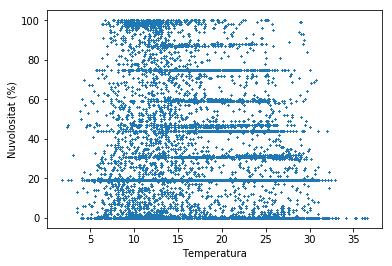

In [14]:
plotname = "temp_nuv"

plt.scatter(db['temperature_value'],db['cloud_cover_value']*100,s=0.01)
plt.xlabel("Temperatura")
plt.ylabel("Nuvolositat (%)")

plt.savefig(figroute+plotname)
plt.show()

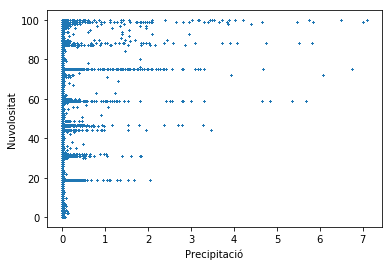

In [15]:
plotname = "nuv_precip"

plt.scatter(db['precip_intensity_value'],db['cloud_cover_value']*100,s=0.01)
plt.xlabel("Precipitació")
plt.ylabel("Nuvolositat")

plt.savefig(figroute+plotname)
plt.show()

- Veiem que el triangle inferior dret esperable existeix però en canvi el triangle superior no és dens, implicant que una alta nuvolositat no ens porta a més precipitació. Per tant, podem elidir aquesta gràfica en la nostra mostra

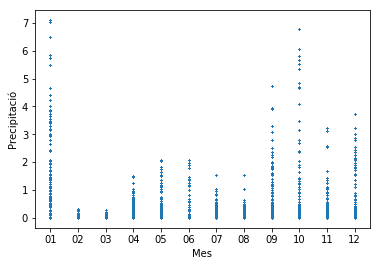

In [16]:
plotname = "month_prec"

plt.scatter(db['month'],db['precip_intensity_value'],s=0.01)
plt.xlabel("Mes")
plt.ylabel("Precipitació")

plt.savefig(figroute+plotname)
plt.show()

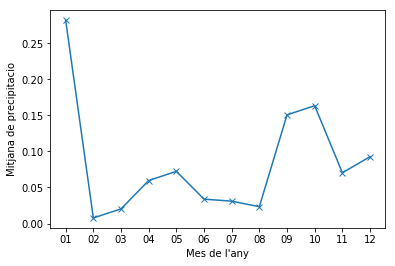

In [69]:
plotname = "mes_precipitacio"

plt.plot(db[db['precip_intensity_value'] < 10].groupby('month').mean()['precip_intensity_value'],marker='x')
#plt.plot([0,23],[1.7,1.7])
plt.xlabel("Mes de l'any")
plt.ylabel("Mitjana de precipitacio")

plt.savefig(figroute+plotname)
plt.show()

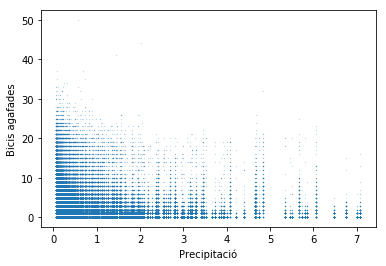

In [22]:
plt.scatter(db[db['precip_intensity_value']>0.05]['precip_intensity_value'],db[db['precip_intensity_value']>0.05]['bikes_taken'],s=0.01)
plt.xlabel("Precipitació")
plt.ylabel("Bicis agafades")
plt.show()

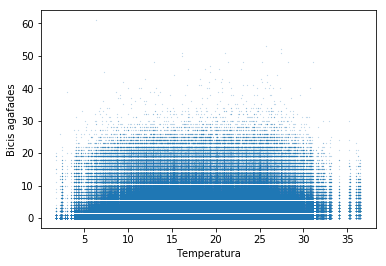

In [25]:
plt.scatter(db['temperature_value'],db['bikes_taken'],s=0.01)
plt.xlabel("Temperatura")
plt.ylabel("Bicis agafades")
plt.show()

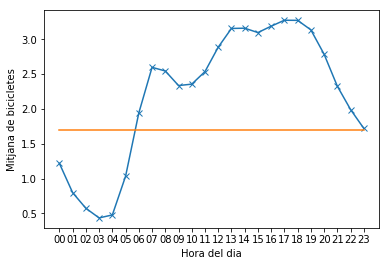

In [269]:
plotname = "hour_bikes"

plt.plot(db[db['bikes_taken'] < 10].groupby('hour').mean()['bikes_taken'],marker='x')
plt.plot([0,23],[1.7,1.7])
plt.xlabel("Hora del dia")
plt.ylabel("Mitjana de bicicletes")

plt.savefig(figroute+plotname,bbox_inches='tight')
plt.show()

In [77]:
x = db[db['bikes_taken'] < 10].groupby('cloud_cover_value').mean()['bikes_taken']
x.index

Float64Index([ 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
              ...
              0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,  1.0],
             dtype='float64', name='cloud_cover_value', length=101)

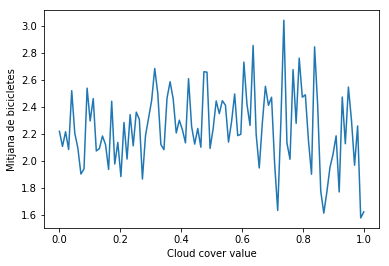

In [85]:
plotname = "cel_bikes_2"

#plt.plot(db[db['bikes_taken'] < 10].groupby('cloud_cover_value').mean()['bikes_taken'],marker='x')
x = db[db['bikes_taken'] < 10].groupby('cloud_cover_value').mean()['bikes_taken']

plt.xlabel("Cloud cover value")
plt.ylabel("Mitjana de bicicletes")


from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(x.index.min(), x.index.max(), 100) 

spl = make_interp_spline(x.index, x, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.savefig(figroute+plotname)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc6d418550>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc6d418ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc6d418400>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc6d4207f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc6d420c50>],
 'means': []}

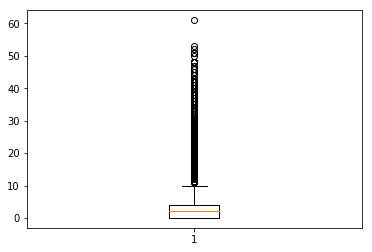

In [101]:
plt.boxplot(db['bikes_taken'])

C:\Users\aleix\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


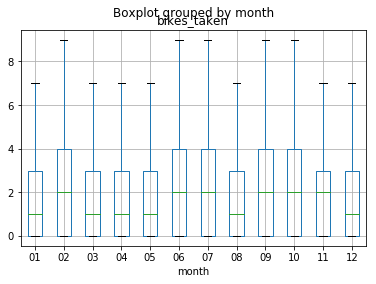

In [123]:
db[db['bikes_taken']<10].boxplot('bikes_taken',by='month',showfliers=False)


# Part 3: preparació de tractament i control
Preparem ara les dades que són tractament i les que són control

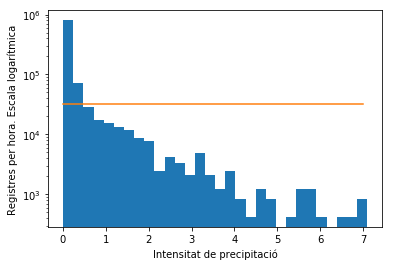

In [87]:
plt.hist(db[db['precip_intensity_value']>0]['precip_intensity_value'],bins=30)
plt.gca().set_yscale("log")
plt.plot([0,7],[10**4.5,10**4.5])
plt.xlabel("Intensitat de precipitació")
plt.ylabel("Registres per hora. Escala logarítmica")

plotname = "hist_rain"
plt.savefig(figroute+plotname)

plt.show()

In [95]:
chosen_rain_threshold = 0.5
chosen_time_threshold = 5
chosen_bike_threshold = 11

In [125]:
total = len(db)
pluja = len(db[db['precip_intensity_value'] > 0])

valors_tractament_totals = pluja
perc_tract = round(pluja/total * 100,2)
valors_control_totals = total-pluja
perc_control = round(valors_control_totals / total*100,2)

In [126]:
exp_db = db[db['precip_intensity_value']>chosen_rain_threshold]
exp_db = exp_db.append(db[db['precip_intensity_value']==0])
exp_db['hour'] = exp_db['hour'].astype(np.int)
exp_db = exp_db[exp_db['hour']>chosen_time_threshold]
exp_db = exp_db[exp_db['bikes_taken']<chosen_bike_threshold]

In [127]:
len_exp_db = len(exp_db)
perc_red = round(len_exp_db / total *100,2)

treatment_exp_db = len(exp_db[exp_db['precip_intensity_value']>0])
perc_treat_exp = round(treatment_exp_db / len_exp_db*100,2)
red_treat_exp = round(treatment_exp_db / valors_tractament_totals*100,2)

control_exp_db = len_exp_db - treatment_exp_db
perc_control_exp = round(control_exp_db / len_exp_db*100,2)
red_control_exp = round(control_exp_db / valors_control_totals*100,2)

In [128]:
print(f'Base de dades inicial: {total}')
print(f'Tractaments base inicial: {valors_tractament_totals}, que suposa un {perc_tract}% del total')
print(f'Control base inicial: {valors_control_totals}, que suposa un {perc_control}% del total')
print("\n")
print(f'Base de dades segmentada: {len_exp_db}, representant un {perc_red}% del total inicial')
print(f'Tractaments post-segmentat: {treatment_exp_db}, que suposa un {perc_treat_exp}% del total segmentat i un {red_treat_exp}% del total de tractaments inicial')
print(f'Control post-segmentat: {control_exp_db}, que suposa un {perc_control_exp}% del total segmentat i un {red_control_exp}% del total de controls inicial')

Base de dades inicial: 3222928
Tractaments base inicial: 1026481, que suposa un 31.85% del total
Control base inicial: 2196447, que suposa un 68.15% del total


Base de dades segmentada: 1655642, representant un 51.37% del total inicial
Tractaments post-segmentat: 91978, que suposa un 5.56% del total segmentat i un 8.96% del total de tractaments inicial
Control post-segmentat: 1563664, que suposa un 94.44% del total segmentat i un 71.19% del total de controls inicial


Separem ara oficialment els dos grups i comprovem el resultat correcte

In [129]:
db_treatment = exp_db[exp_db['precip_intensity_value']>0]
print(len(db_treatment))
db_control = exp_db[exp_db['precip_intensity_value']==0]
print(len(db_control))

91978
1563664


Fem un primer estudi molt ràpid de l'ATE directament sobre les nostres dades sense cap tipus de condicionament ni control. Evidentment, és una dada experimentalment no significativa ja que conté tots els múltipls biaixos, però ens dóna una primera aproximació a confirmar una diferència entre els valors.

In [131]:
print(np.mean(db_treatment['bikes_taken']))
print(np.mean(db_control['bikes_taken']))
print("\n")
print("Diferència absoluta de mitjanes (\"ATE\")")
print(np.mean(db_treatment['bikes_taken'])-np.mean(db_control['bikes_taken']))
print("\n")
print("Diferència relativa de mitjanes")
print((np.mean(db_treatment['bikes_taken'])-np.mean(db_control['bikes_taken']))/np.mean(db_control['bikes_taken']))

1.8245558720563613
2.8450575059603596


Diferència absoluta de mitjanes ("ATE")
-1.0205016339039983


Diferència relativa de mitjanes
-0.3586927968120364


# PART 4: anàlisi


In [142]:
def cerca_parella(row):
    estacio = row['station_id']
    mes = row['month']
    hora = row['hour']
    WD = row['WD']
    
    parelles = db_control[
        (db_control['station_id'] == estacio) & 
        (db_control['month'] == mes) &
        (db_control['hour'] == hora) &
        (db_control['WD'] == WD)
    ]
    
    return(len(parelles))

In [143]:
db_treatment['num_parelles'] = db_treatment.apply(cerca_parella,axis=1)

C:\Users\aleix\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


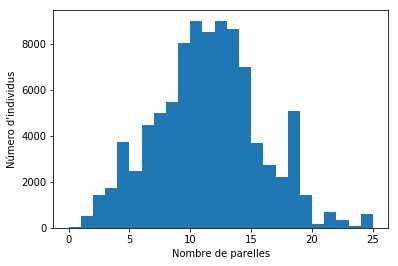

In [149]:
plt.hist(db_treatment['num_parelles'],bins=25)
plt.xlabel("Nombre de parelles")
plt.ylabel("Número d'individus")

plotname = "hist_matching"
plt.savefig(figroute+plotname)

plt.show()

In [157]:
print(len(db_treatment[db_treatment['num_parelles']==0]))
print(len(db_treatment[db_treatment['num_parelles']==0])/len(db_treatment)*100)
print(len(db_treatment[db_treatment['num_parelles']==1]))
print(len(db_treatment[db_treatment['num_parelles']==1])/len(db_treatment)*100)
print(100-len(db_treatment[db_treatment['num_parelles']==1])/len(db_treatment)*100)
print(db_treatment['num_parelles'].mean())

33
0.035878144773750245
494
0.5370849550979582
99.46291504490205
11.006273239252865


In [158]:
db_treatment = db_treatment[db_treatment['num_parelles']>0]

In [160]:
db_treatment.head(1)

date_ref        date  hour  station_id  bikes_taken  \
223  2020-01-10 07  2020-01-10     7           1          0.0   

     temperature_value  sky_condition  precip_intensity_value  \
223                9.1              5                    1.93   

     cloud_cover_value   datetime month day  DayofWeek    WD  num_parelles  
223               0.99 2020-01-10    01  10          5  True             5

In [219]:
def cerca_parella_perfecta(row):
    estacio = row['station_id']
    mes = row['month']
    hora = row['hour']
    WD = row['WD']
    temperatura = row['temperature_value']
    
    parelles = db_control[
        (db_control['station_id'] == estacio) & 
        (db_control['month'] == mes) &
        (db_control['hour'] == hora) &
        (db_control['WD'] == WD)
    ]
    
    match_id = (parelles['temperature_value']-temperatura).abs().sort_values().index[0]
    
    return(match_id)

In [220]:
db_treatment['match_id'] = db_treatment.apply(cerca_parella_perfecta,axis=1)

C:\Users\aleix\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [221]:
def bikes_matching(row):
    return db_control.loc[row['match_id']]['bikes_taken']

In [222]:
db_treatment['bikes_from_match'] = db_treatment.apply(bikes_matching,axis=1)

C:\Users\aleix\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [224]:
dif_daily = db_treatment['bikes_taken'] - db_treatment['bikes_from_match']
dif_daily.mean()

In [226]:
(db_treatment['bikes_taken'].mean() - db_treatment['bikes_from_match'].mean())/db_treatment['bikes_from_match'].mean()

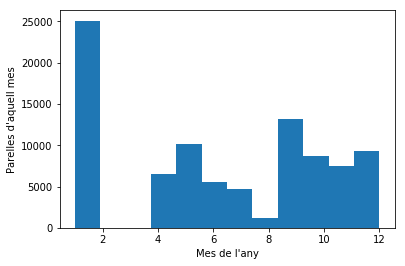

In [235]:
plt.hist(db_treatment['month'].astype('int'),bins=12)

plt.xlabel("Mes de l'any")
plt.ylabel("Parelles d'aquell mes")

plotname = "month_matching"
plt.savefig(figroute+plotname)

plt.show()

In [260]:
ATE_mes = pd.DataFrame(columns=['Month','Absolute_dif','Percentual_dif'])

for i in range(1,13):
    absolute = round(db_treatment[db_treatment['month'] == i]['bikes_taken'].mean() - db_treatment[db_treatment['month'] == i]['bikes_from_match'].mean(),2)
    percentual = round((db_treatment[db_treatment['month'] == i]['bikes_taken'].mean() - db_treatment[db_treatment['month'] == i]['bikes_from_match'].mean())/db_treatment[db_treatment['month'] == i]['bikes_from_match'].mean()*100,2)
    
    ATE_mes = ATE_mes.append(pd.DataFrame([{'Month':i,'Absolute_dif':absolute,'Percentual_dif':percentual}]),ignore_index=True)

In [261]:
ATE_mes.
print(ATE_mes)

   Month  Absolute_dif  Percentual_dif
0      1         -1.44          -47.67
1      2           NaN             NaN
2      3           NaN             NaN
3      4         -0.53          -17.64
4      5         -1.53          -50.06
5      6         -2.20          -60.90
6      7         -0.31           -9.30
7      8          0.16            6.66
8      9         -1.06          -35.76
9     10         -0.50          -16.88
10    11         -0.74          -25.61
11    12         -2.14          -69.25


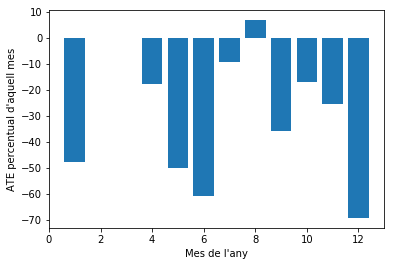

In [272]:
plt.bar(ATE_mes['Month'],ATE_mes['Percentual_dif'])

plt.xlabel("Mes de l'any")
plt.ylabel("ATE percentual d'aquell mes")

plotname = "month_ATE"
plt.savefig(figroute+plotname)

plt.show()

## Part 4.1. Ús de l'eina DoWhy
Agafem una representació menor de la nostra mostra per poder fer l'anàlisi

Definim el gràfic causal. En aquest cas, triem fer-ho amb GML que és l'opció que millor reconeix DoWhy. De cara a seguir el notebook, tenir en compte que DoWhy utilitza els Warnings per tal d'informar de l'estat de l'anàlisi o corroborar què s'està analitzant, sense voler dir que sigui un error en sí. Per tal de poder realitza el càlcul a nivell computacional farem servir el mateix nivell de tractament i una sample de controls de dos cops els valors de tractament

In [285]:
dowhy_treatment = db_treatment
dowhy_control = db_control.sample(len(db_treatment)*2)
db_dowhy = dowhy_treatment.append(dowhy_control)
db_dowhy['treatment'] = db_dowhy['precip_intensity_value'] > 0.5
db_dowhy['treatment']

223         True
224         True
225         True
226         True
227         True
           ...  
165535     False
1166090    False
1771293    False
2371544    False
106890     False
Name: treatment, Length: 275835, dtype: bool

In [292]:
db_dowhy['month'] = db_dowhy['month'].astype('int')

In [281]:
causal_graph = 'graph[directed 1node[ id "W" label "treatment"]node[ id "Y" label "bikes_taken"]node[ id "Z1" label "month"]node[ id "Z2" label "temperature_value"]node[ id "WD" label "WD"]node[ id "Z3" label "sky_condition"]edge[source "W" target "Y"]edge[source "Z1" target "W"]edge[source "Z1" target "Y"]edge[source "Z1" target "Z2"]edge[source "WD" target "Y"]edge[source "Z2" target "Y"]edge[source "Z1" target "WD"]edge[source "Z3" target "Y"]]'

In [286]:
model=CausalModel(
        data = db_dowhy,
        treatment=["treatment"],
        outcome="bikes_taken",
        graph=causal_graph,
        #instruments=['temperature_value','sky_condition'],
        logging_level = logging.INFO
        )

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['bikes_taken']


Comprovem amb view_model() que ens ha reconegut correctament el model especificat

INFO:dowhy.causal_graph:Using Matplotlib for plotting


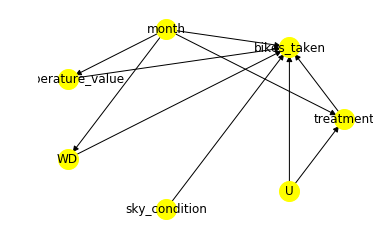

In [287]:
model.view_model()


Comencem identificant l'estimant

In [293]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['month', 'U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                      
────────────(Expectation(bikes_taken|month))
d[treatment]                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→bikes_taken then P(bikes_taken|treatment,month,U) = P(bikes_taken|treatment,month)
### Estimand : 2
Estimand name: iv
No such variable found!



Fem ara l'anàlisi causal en sí. Comencem fent l'estimació de l'ATE a partir del matching

In [294]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: bikes_taken~treatment+month
C:\Users\aleix\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                      
────────────(Expectation(bikes_taken|month))
d[treatment]                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→bikes_taken then P(bikes_taken|treatment,month,U) = P(bikes_taken|treatment,month)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: bikes_taken~treatment+month
Target units: ate

## Estimate
Mean value: -1.4989323327351496

Causal Estimate is -1.4989323327351496


In [299]:
print("####### Model {}#############################################################################################".format(model))
print("Common Causes:",model._common_causes)
print("Effect Modifiers:",model._effect_modifiers)
print("Instruments:",model._instruments)
print("Outcome:",model._outcome)
print("Treatment:",model._treatment)
print("#############################################################################################################")

####### Model <dowhy.causal_model.CausalModel object at 0x0000019399D2CCC0>#############################################################################################
Common Causes: ['month', 'U']
Effect Modifiers: ['sky_condition', 'WD', 'temperature_value']
Instruments: []
Outcome: ['bikes_taken']
Treatment: ['treatment']
#############################################################################################################
